In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
import math
import random
import cvxopt
from cvxopt import matrix, solvers
import pypfopt
from scipy.optimize import minimize
%matplotlib inline

In [2]:
tickers_list = ['TSLA','LAC',
                'AMZN', 'NFLX',
                'WMT', 'COST',
               'FL', 'RILY',
               'ENPH', 'SHOP',
               'PLUG', 'SEDG',
               'ETSY', 'MRTX',
               'TJX', 'NKE',
               'AAPL', 'FB',
               'GOOG', 'NVDA']

df = yf.download(tickers_list,'2020-01-01', '2021-10-31')['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [3]:
df

,AAPL,AMZN,COST,ENPH,ETSY,FB,FL,GOOG,LAC,MRTX,NFLX,NKE,NVDA,PLUG,RILY,SEDG,SHOP,TJX,TSLA,WMT
Date,,,,,,,,,,,,,,,,,,,,
2019-12-31,72.337990,1847.839966,281.855011,26.129999,44.299999,205.250000,37.159405,1337.020020,3.170000,128.860001,323.570007,99.604668,58.676849,3.160000,19.857351,95.089996,397.579987,59.943466,83.666000,115.522278
2020-01-02,73.988487,1898.010010,279.524750,29.340000,45.189999,209.779999,36.301662,1367.369995,3.300000,116.209999,329.809998,100.479691,59.826443,3.240000,19.754833,101.809998,407.809998,60.571758,86.052002,115.619484
2020-01-03,73.269165,1874.969971,279.754852,29.290001,44.900002,208.669998,36.311192,1360.660034,3.520000,113.199997,325.899994,100.204399,58.868858,3.230000,19.912558,102.379997,404.290009,60.120174,88.601997,114.598801
2020-01-06,73.852982,1902.880005,279.831604,29.660000,44.834999,212.600006,36.968792,1394.209961,3.630000,114.330002,335.829987,100.115913,59.115730,3.820000,19.865240,99.629997,413.329987,60.503040,90.307999,114.365501
2020-01-07,73.505646,1906.859985,279.390503,29.990000,45.779999,213.059998,37.502502,1393.339966,3.630000,102.769997,330.750000,100.066742,59.831429,3.810000,19.881010,101.790001,414.500000,60.463772,93.811996,113.305931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,148.423386,3320.370117,489.308411,179.429993,252.570007,328.690002,49.389999,2775.459961,26.650000,186.389999,671.659973,163.925369,231.631638,34.880001,61.266010,311.920013,1425.160034,65.017227,1024.859985,150.059998
2021-10-26,149.102402,3376.070068,484.745789,173.460007,247.520004,315.809998,48.270000,2793.439941,27.459999,188.089996,668.520020,163.496140,247.139740,34.169998,59.573681,313.880005,1363.699951,65.086967,1018.429993,148.750000
2021-10-27,148.633087,3392.489990,488.319977,216.220001,243.889999,312.220001,46.900002,2928.550049,26.420000,186.949997,662.919983,162.058731,244.480057,34.410000,58.851116,342.540009,1361.119995,64.319824,1037.859985,147.529999


In [4]:
'''
This cell computes the number of missing values in the datframe
'''
stocks = []
nans = []
for i in df.columns:
    stocks.append(i)
    count_nan = df[str(i)].isna().sum()
    nans.append(count_nan)

nan_df = pd.DataFrame(stocks)
nan_df['nans'] = nans

In [5]:
nan_df.columns = ['stock', 'nan values']

In [6]:
#calculate the daily returns of each stock
daily_returns = df.pct_change()
daily_returns = daily_returns.iloc[1:,:]

In [7]:
#get average daily returns
mean_daily_returns = daily_returns.values.mean(axis=0)

In [8]:
#Normalise daily returns and calculate covariance matrix, eigen values and eigen vectors
Y = daily_returns.values - mean_daily_returns
cov = np.cov(Y.T)
eigen_values, eigen_vectors = np.linalg.eig(cov)

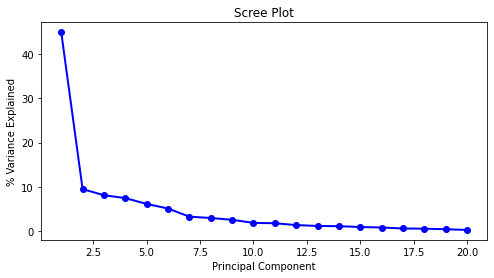

91.56180506723523


In [9]:
#Scree plot
x = eigen_values
w = []
z = []
cnt = 1
for i in x:
    w.append(100*(i/sum(x)))
    z.append(cnt)
    cnt+=1
    
w = sorted(w, key=float, reverse=True)
plt.rcParams["figure.figsize"] = (8, 4)
plt.plot(z, w,'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')
plt.show()

x=0
for i in range(0,10):
    x += w[i]
    
print(x)

In [10]:
#calculate factor loadings
factor_loading = pd.DataFrame(eigen_vectors)
factor_loading.columns = ['FL1', 'FL2', 'FL3', 'FL4', 'FL5', 'FL6','FL7', 'FL8', 'FL9', 'FL10', 'FL11', 'FL12',
                   'FL13', 'FL14', 'FL15', 'FL16','FL17', 'FL18', 'FL19', 'FL20']
factor_loading.index = daily_returns.columns
factor_loading

,FL1,FL2,FL3,FL4,FL5,FL6,FL7,FL8,FL9,FL10,FL11,FL12,FL13,FL14,FL15,FL16,FL17,FL18,FL19,FL20
AAPL,-0.144839,0.181677,-0.163590,-0.003154,-0.051040,0.008247,0.162644,-0.111879,-0.051909,-0.087778,0.151992,-0.068111,0.257737,0.654804,-0.440637,-0.140451,0.198994,0.271106,-0.130459,0.016114
AMZN,-0.102586,0.163918,-0.128458,0.067788,0.046424,-0.006232,0.160827,-0.128453,-0.125345,0.008934,0.059862,-0.103355,-0.418195,-0.508177,-0.580095,0.154496,0.086310,0.158421,-0.144221,0.141554
COST,-0.064860,0.110120,-0.088984,0.001819,-0.043511,-0.013280,0.109724,-0.072418,-0.068060,-0.058158,0.141249,0.797916,-0.099518,-0.092839,0.177184,-0.059851,0.178372,0.381105,0.219523,-0.114059
ENPH,-0.404810,0.157237,0.618958,-0.173428,0.051157,0.043272,0.136468,-0.044582,0.245027,0.510206,0.205438,-0.016154,0.005049,-0.021570,0.016893,-0.045973,0.067389,0.035569,-0.036630,-0.016318
ETSY,-0.230529,0.188523,-0.054370,0.164328,0.092427,-0.579171,-0.633066,-0.020716,-0.077621,-0.015972,0.341402,0.000431,0.021384,-0.031016,0.010412,-0.056555,-0.039869,-0.045584,-0.067912,-0.018190
FB,-0.124019,0.180010,-0.204098,-0.005193,-0.041742,-0.008736,0.243379,-0.147650,-0.092067,-0.005002,0.072747,-0.043969,-0.364135,0.149946,0.493158,-0.046102,-0.108245,-0.057629,-0.629688,0.000451
FL,-0.126950,-0.042122,-0.135102,-0.358936,-0.545097,0.050545,-0.278057,0.119701,-0.302359,0.323545,-0.148385,0.018719,-0.026188,0.079311,0.041881,0.253957,-0.006934,0.147299,0.019001,0.360403
GOOG,-0.112116,0.144601,-0.156668,-0.033126,-0.090074,0.030950,0.163422,-0.094345,-0.071548,-0.015502,0.036826,0.009017,0.762990,-0.465772,0.079050,-0.035157,-0.132619,0.041387,-0.249103,0.038309
LAC,-0.398778,-0.641093,-0.300146,-0.363123,0.372307,-0.202274,0.140809,-0.020829,-0.011507,0.046048,0.035547,-0.004415,0.012456,-0.013732,0.000769,0.006358,0.060475,-0.002613,0.018209,-0.018028
MRTX,-0.160346,0.117007,-0.135710,0.069076,-0.054841,-0.059231,0.178309,0.906883,0.209705,-0.077477,0.113447,0.028537,-0.017522,-0.021703,-0.029173,0.075834,0.004356,-0.004625,-0.073527,-0.013139


In [11]:
#Determine highest contributer to each factor
m = []
for i in factor_loading.columns:
    a = min((factor_loading[i]))
    b = max(factor_loading[i])
    
    if abs(a) > abs(b):
        y =factor_loading[i].to_list()
        y = y.index(a)
        m.append(daily_returns.columns[y])
    else:
        y =factor_loading[i].to_list()
        y = y.index(b)
        m.append(daily_returns.columns[y])

print(m)

['PLUG', 'LAC', 'ENPH', 'PLUG', 'FL', 'TSLA', 'ETSY', 'MRTX', 'RILY', 'SEDG', 'SHOP', 'COST', 'GOOG', 'AAPL', 'AMZN', 'NFLX', 'NKE', 'WMT', 'FB', 'TJX']


In [12]:
#determine the factors to be used 
factors = np.matmul(Y , eigen_vectors)
factors = pd.DataFrame(factors)
factors = factors.iloc[:,0:10]
factors.columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6','F7', 'F8', 'F9', 'F10']
factors

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
0,-0.102043,0.018575,0.083002,-0.026272,0.043413,0.004406,0.014922,-0.108291,-0.022845,0.023275
1,-0.002302,-0.055619,-0.008677,-0.033185,0.036136,0.014568,-0.015402,-0.016196,0.000230,-0.003619
2,-0.093423,-0.074815,-0.015881,0.118057,-0.061195,0.021923,0.025180,-0.012783,-0.014178,0.026842
3,0.003438,0.001426,0.021173,-0.017409,0.016040,0.020743,-0.049766,-0.084554,-0.031675,0.003877
4,-0.043848,0.017200,0.028574,0.051844,-0.022358,0.056080,0.010698,0.009904,-0.004885,-0.003236
...,...,...,...,...,...,...,...,...,...,...
457,-0.113885,-0.029681,-0.031436,0.012117,0.026367,0.062312,-0.068103,-0.026204,-0.012850,-0.014494
458,0.035158,-0.018557,-0.019339,-0.019341,0.025496,0.001750,0.035417,0.017810,-0.029010,-0.026244
459,-0.095393,0.070784,0.209652,-0.039226,0.023530,0.037180,0.043125,-0.011896,0.030007,0.055502
460,-0.113633,-0.017216,-0.015605,0.022246,-0.006517,0.013511,0.013915,-0.022509,0.031264,0.001209


In [13]:
#Minimise for volatility and calculate the optimal weighting of each factor
daily_factor_returns = factors.mean() 
daily_factor_returns
annual_factor_returns = daily_factor_returns*252
cov = factors.cov()*252 

In [14]:
volatility_constraint = 0.3

def solve_for_max_returns(p):
    p = np.array(p)
    R = np.sum(annual_factor_returns*p)
    return -1*R

def weights_check(p):
    return np.sum(p)-1

def volatility(p):
    p = np.array(p)
    V = np.sqrt(np.dot(p.T,np.dot(cov,p))) 
    return V

#inital weights, bounds and constraints
p0 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
constraints = ({'type':'eq', 'fun':weights_check},
                {'type':'eq', 'fun': lambda p: volatility(p) - volatility_constraint})
#solve for the optimal factor weightings
p_opt = minimize(solve_for_max_returns, p0, method = 'SLSQP', bounds = bounds, constraints=constraints)
p_opt_weightings = p_opt.x
p_volatility = volatility(p_opt_weightings)*100
p_volatility

20.00000044312905

In [15]:
factor_weights = []
for i in p_opt.x:
    factor_weights.append(i)   
factor_weights

[0.04242438625225916,
 0.09809255190892394,
 0.10072962957312713,
 0.1019709794898518,
 0.10451815527705327,
 0.10655180048862262,
 0.11021914482887987,
 0.11080693391158562,
 0.11163192739289698,
 0.11305449087679971]

In [17]:
#Determine the optimal portfolio
eigen_vectors = pd.DataFrame(eigen_vectors)
factor_eigen_vectors = eigen_vectors.iloc[:,0:10]
factor_eigen_vectors = abs(factor_eigen_vectors)
factor_eigen_vectors = factor_eigen_vectors/factor_eigen_vectors.sum(axis=0) #weighting of each stock in each factor

mean_annual_returns = mean_daily_returns*252


portfolio_weights = np.matmul(factor_loading,factor_weights)
portfolio_weights

portfolio_stock_returns = portfolio_weights*mean_annual_returns
portfolio_stock_returns

portfolio_annual_return = round(sum(100*portfolio_stock_returns),2)

print(f"Annual Portfolio Return: {portfolio_annual_return}%")
print(f"Portfolio Volatility: {np.round(p_volatility,)}%")

ValueError: Dot product shape mismatch, (20, 20) vs (10,)